In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from temgym_core.source import ParallelBeam
from temgym_core.components import Detector, Lens, AberratedLensKrivanek
from temgym_core.gaussian import GaussianRay, evaluate_gaussian_input_image, make_gaussian_image
from temgym_core.aberrations import W_krivanek, KrivanekCoeffs
from temgym_core.utils import fibonacci_spiral
from temgym_core.run import run_to_end

import numpy as np
import abtem

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase

jax.config.update("jax_enable_x64", True)

In [2]:
scale = 1  # scale to microns

aperture_window_width = 1
num_aper_pixels = 256
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = 0.25

num_beams = int(1e3)
r1x = np.zeros(num_beams)
r1y = np.linspace(-aperture_radius, aperture_radius, num_beams)

wavelength = 1e-4
k = 2 * np.pi / wavelength
wo = 0.01

aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

In [3]:
# Gaussian Beam Input
xs = r1x * 0.0
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


In [4]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)


In [5]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=100)

Text(0.5, 1.0, 'Gauss Phase at input plane')

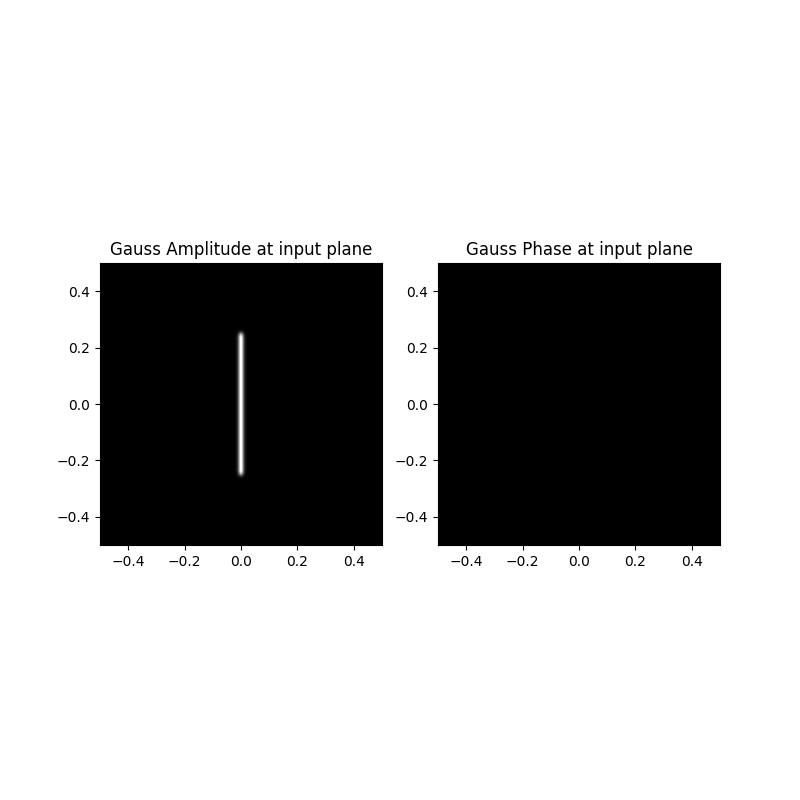

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# Amplitude at input plane
ax[0].imshow(jnp.abs(aperture_image), cmap='gray', extent=[-aperture_window_width/2, aperture_window_width/2, -aperture_window_width/2, aperture_window_width/2])
ax[0].set_title('Gauss Amplitude at input plane')

# Phase at input plane
ax[1].imshow(jnp.angle(aperture_image), cmap='gray', extent=[-aperture_window_width/2, aperture_window_width/2, -aperture_window_width/2, aperture_window_width/2])
ax[1].set_title('Gauss Phase at input plane')

In [7]:
F1 = 1000
defocus = 1e-13
pixel_size_bfp = wavelength * abs(F1) / (aperture_window_width)
coeffs = KrivanekCoeffs(C30=0.0, C21=0.0, C12=0.0, C23=0.0, C32=0.0)
parallel_beam = ParallelBeam(z=0.0, radius=aperture_radius)
lens = Lens(focal_length=F1, z=0.0)
detector = Detector(z=defocus, pixel_size=(aperture_pixel_size[0], aperture_pixel_size[1]), shape=(num_aper_pixels, num_aper_pixels))
detector_xy = detector.coords_1d
extent_x = detector.coords_1d[0][0], detector.coords_1d[0][-1]
extent_y = detector.coords_1d[1][0], detector.coords_1d[1][-1]

print(extent_x, extent_y)
model = [
    parallel_beam,
    lens,
    detector,
]

input_rays = rays.derive(z=jnp.zeros(num_beams))
det_image_at_lens = make_gaussian_image(input_rays, model, batch_size=100)

(Array(-0.49804688, dtype=float64), Array(0.49804688, dtype=float64)) (Array(0.49804688, dtype=float64), Array(-0.49804688, dtype=float64))


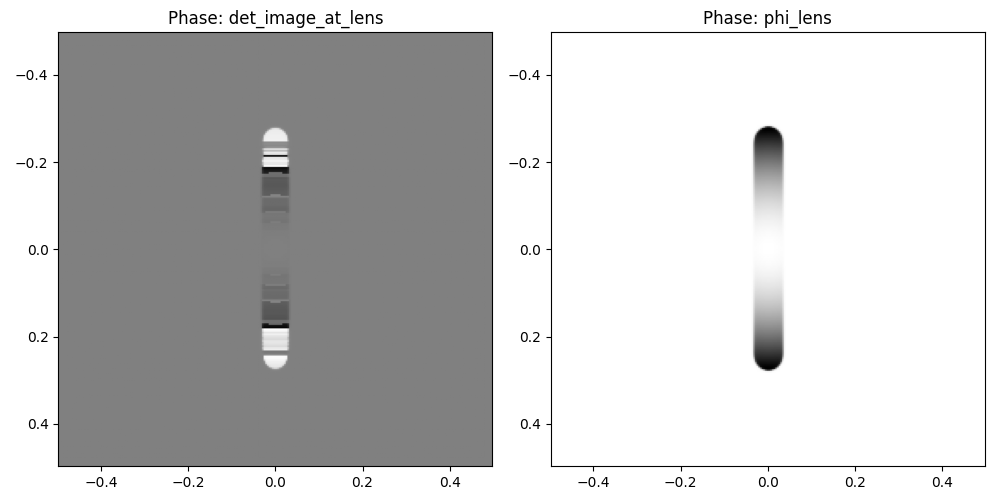

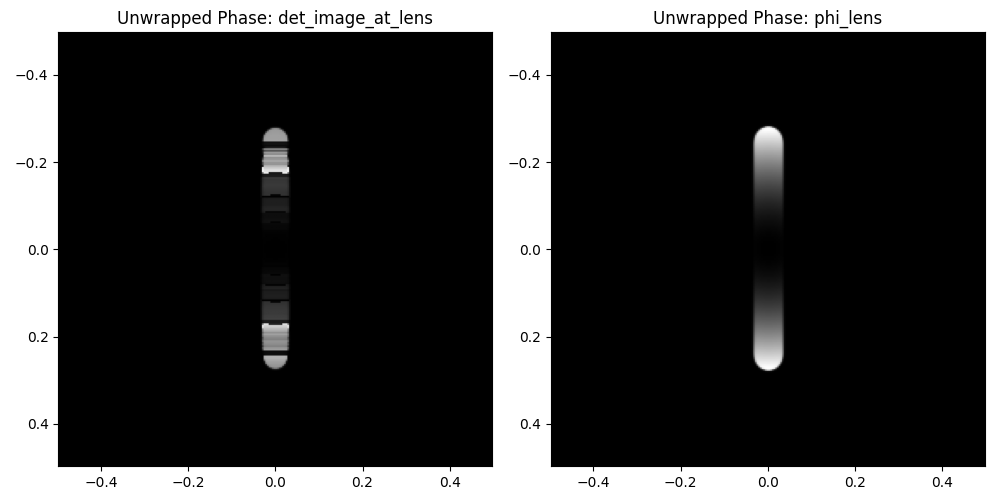

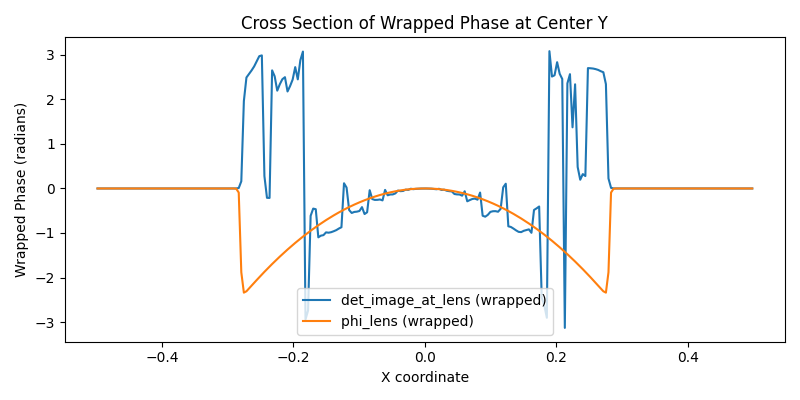

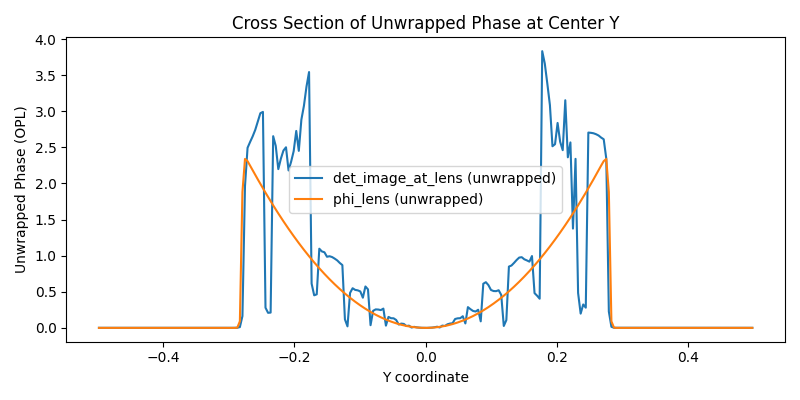

In [8]:
detector_coords = detector.coords
X, Y = detector_coords[:, 0], detector_coords[:, 1]
X = X.reshape((num_aper_pixels, num_aper_pixels))
Y = Y.reshape((num_aper_pixels, num_aper_pixels))   

phi_lens = np.exp(1j * (k * (-1/F1) / 2.0) * (X**2 + Y**2))
phi_lens = phi_lens * np.abs(aperture_image)

# Zero the phase by subtracting the phase at the center pixel
center_idx = num_aper_pixels // 2
det_image_at_lens -= np.angle(det_image_at_lens[center_idx, center_idx])
phi_lens -= np.angle(phi_lens[center_idx, center_idx])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(jnp.angle(det_image_at_lens), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Phase: det_image_at_lens')
im1 = axs[1].imshow(np.angle(phi_lens), cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Phase: phi_lens')
plt.tight_layout()

# Unwrap the phase of both images
unwrapped_det_image_at_lens = unwrap_phase(np.angle(det_image_at_lens))
unwrapped_phi_lens = unwrap_phase(np.angle(phi_lens))

unwrapped_det_image_at_lens = np.abs(unwrapped_det_image_at_lens - unwrapped_det_image_at_lens[center_idx, center_idx])
unwrapped_phi_lens = np.abs(unwrapped_phi_lens - unwrapped_phi_lens[center_idx, center_idx])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(unwrapped_det_image_at_lens, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[0].set_title('Unwrapped Phase: det_image_at_lens')
im1 = axs[1].imshow(unwrapped_phi_lens, cmap='gray', extent=(extent_x[0], extent_x[1], extent_y[0], extent_y[1]))
axs[1].set_title('Unwrapped Phase: phi_lens')
plt.tight_layout()

# Plot cross section of wrapped phase at center_idx along x-axis
plt.figure(figsize=(8, 4))
plt.plot(Y[:,center_idx], np.angle(det_image_at_lens[:,center_idx]), label='det_image_at_lens (wrapped)')
plt.plot(Y[:,center_idx], np.angle(phi_lens[:,center_idx]), label='phi_lens (wrapped)')
plt.xlabel('X coordinate')
plt.ylabel('Wrapped Phase (radians)')
plt.title('Cross Section of Wrapped Phase at Center Y')
plt.legend()
plt.tight_layout()

# Plot a cross section of the unwrapped phase at center_idx along x-axis
plt.figure(figsize=(8, 4))
plt.plot(Y[:,center_idx], unwrapped_det_image_at_lens[:,center_idx], label='det_image_at_lens (unwrapped)')
plt.plot(Y[:,center_idx], unwrapped_phi_lens[:,center_idx], label='phi_lens (unwrapped)')
plt.xlabel('Y coordinate')
plt.ylabel('Unwrapped Phase (OPL)')
plt.title('Cross Section of Unwrapped Phase at Center Y')
plt.legend()
plt.tight_layout()

In [9]:
out_rays = run_to_end(input_rays, model)

(-0.04, 0.060000000000000005)

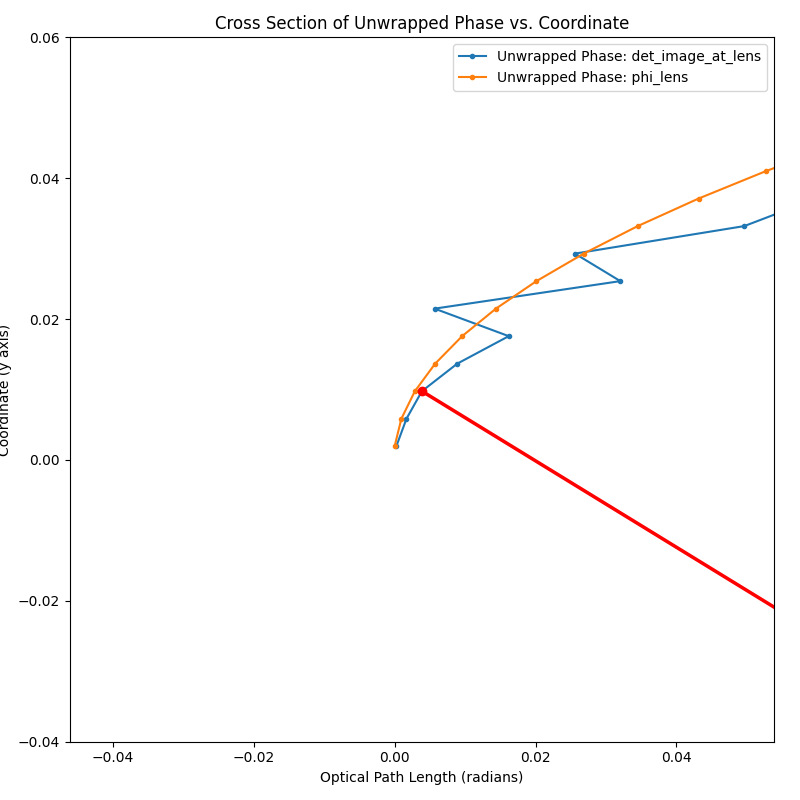

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

# Only plot for y >= 0
mask = detector_xy[1] >= 0
y_mask = detector_xy[1][mask]
phi_mask = unwrapped_det_image_at_lens[mask, center_idx]
phi_lens_mask = unwrapped_phi_lens[mask, center_idx]

ax.plot(phi_mask, y_mask, label='Unwrapped Phase: det_image_at_lens', marker='.')
ax.plot(phi_lens_mask, y_mask, label='Unwrapped Phase: phi_lens', marker='.')

ax.set_xlabel('Optical Path Length (radians)')
ax.set_ylabel('Coordinate (y axis)')
ax.set_title('Cross Section of Unwrapped Phase vs. Coordinate')
ax.legend()
fig.tight_layout()

y_target = 0.01
i_mask = np.abs(y_mask - y_target).argmin()
y0 = float(y_mask[i_mask])
phi0 = float(phi_mask[i_mask])

idx_ray = (np.abs(out_rays.y - y0)).argmin()

p = float(out_rays.dy[idx_ray])  # slope p = dy/dz

n_medium = 1.0         # refractive index
k0 = 2*np.pi / wavelength
m_ray = (k0 * n_medium) * p / np.sqrt(1.0 + p*p)

N = np.array([-1.0, m_ray], dtype=float)
N /= np.linalg.norm(N) if np.linalg.norm(N) != 0 else 1.0

Lphi = 0.05 * (np.nanmax(phi_mask) - np.nanmin(phi_mask) + 1e-12)
u, v = -N * Lphi   # (Δφ, Δy)

ax.plot(phi0, y0, 'ro', label='Point on curve')
ax.quiver(phi0, y0, u, -v,
          angles='xy', scale_units='xy', scale=1,
          width=0.005, color='r', label='Normal to curve (from ray slope)')

ax.set_aspect('equal')
ax.set_xlim(phi0 - 0.05, phi0 + 0.05)
ax.set_ylim(y_target - 0.05, y_target + 0.05)


In [11]:
# --- build tangent/normal using the local slope m_ray ---
m = float(m_ray)

# Tangent to φ(y) at (φ0, y0) has direction (m, 1)
T_hat = np.array([m, 1.0], dtype=float)
T_hat /= np.linalg.norm(T_hat) if np.linalg.norm(T_hat) != 0 else 1.0

# Normal is (-1, m)
N_hat = np.array([-1.0, m], dtype=float)
N_hat /= np.linalg.norm(N_hat) if np.linalg.norm(N_hat) != 0 else 1.0

# --- parameter along tangent in *meters* (y-units) ---
smax = 0.1 * (np.nanmax(y_mask) - np.nanmin(y_mask) + 1e-12)  # meters
s = np.linspace(-smax, smax, 10000)  # meters along y

# Tangent line: y(s) = y0 + s, φ(s) = φ0 + m*s
phi_tan = phi0 + m * s
y_tan   = y0  - s
ax.plot(phi_tan, y_tan, '--', lw=1.5, color='k', label='Tangent (⊥ ray)', zorder=3)

# --- Gaussian along the tangent with width wo (meters) ---
sigma_y = float(wo)              # meters
A_y = 0.3 * smax                 # display amplitude in meters (normal offset in y)
g = 0.5 * np.exp(-0.5 * (s / sigma_y)**2)

# Offset the curve along the *normal* by A_y*g (in meters along y).
# Convert that y-offset into (Δφ, Δy) in axis units using N_hat’s ratio.
eps = 1e-15
if abs(N_hat[1]) > eps:
    alpha = (A_y * g) / N_hat[1]      # scalar so that Δy = alpha * N_hat[1] = A_y*g
else:
    # rare: normal is ~horizontal; fall back to φ-amplitude
    A_phi = 0.25 * (np.nanmax(phi_mask) - np.nanmin(phi_mask) + 1e-12)
    alpha = (A_phi * g) / (np.sign(N_hat[0]) + eps)

phi_gauss = phi_tan - alpha * N_hat[0]
y_gauss   = y_tan   + alpha * N_hat[1]

ax.plot(phi_gauss, y_gauss, lw=2, color='C3', label='Gaussian on tangent', zorder=4)
